Q1) res0: String = 3.0.3

In [54]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import types
from pyspark.sql.functions import *

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('test') \
    .getOrCreate()

22/02/28 11:46:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
schema = types.StructType([
    types.StructField('hvfhs_license_num', types.StringType(), True),
    types.StructField('dispatching_base_num', types.StringType(), True),
    types.StructField('pickup_datetime', types.TimestampType(), True),
    types.StructField('dropoff_datetime', types.TimestampType(), True),
    types.StructField('PULocationID', types.IntegerType(), True),
    types.StructField('DOLocationID', types.IntegerType(), True),
    types.StructField('SR_Flag', types.StringType(), True)
])

In [33]:
#df = spark.read \
#    .option("header", "true") \
#    .schema(schema) \
#    .csv('fhvhv_tripdata_2021-02.csv')
#df = df.repartition(24)
#df.write.mode("overwrite").parquet('fhvhv/2021/02/')

In [79]:
df = spark.read.parquet('fhvhv/2021/02/')

In [43]:
df.schema

StructType(List(StructField(hvfhs_license_num,StringType,true),StructField(dispatching_base_num,StringType,true),StructField(pickup_datetime,TimestampType,true),StructField(dropoff_datetime,TimestampType,true),StructField(PULocationID,IntegerType,true),StructField(DOLocationID,IntegerType,true),StructField(SR_Flag,StringType,true)))

In [42]:
!du -sh fhvhv/2021/02/

210M	fhvhv/2021/02/


Q2) 👆

In [80]:
df.registerTempTable('trips_data')

In [10]:
spark.sql("""
SELECT
    COUNT(*)
FROM
    trips_data
WHERE EXTRACT('day', pickup_datetime) = 15
""").show()

+--------+
|count(1)|
+--------+
|  367170|
+--------+



Q3) 👆

In [47]:
df.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- SR_Flag: string (nullable = true)



In [71]:
df.select(col("pickup_datetime"), (unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))).alias("datediff") ) \
    .orderBy(col("datediff").desc())\
    .show(1)

+-------------------+--------+
|    pickup_datetime|datediff|
+-------------------+--------+
|2021-02-11 13:40:44|   75540|
+-------------------+--------+
only showing top 1 row



In [74]:
spark.sql("""
SELECT
    pickup_datetime,
    (unix_timestamp(dropoff_datetime) - unix_timestamp(pickup_datetime)) as datediff
FROM
    trips_data
ORDER BY 
    2 DESC
LIMIT 1
""").show()

+-------------------+--------+
|    pickup_datetime|datediff|
+-------------------+--------+
|2021-02-11 13:40:44|   75540|
+-------------------+--------+



Q4) 👆

In [12]:
spark.sql("""
SELECT
    dispatching_base_num,
    COUNT(*)
FROM
    trips_data
GROUP BY 
    1
ORDER BY 
    2 DESC
LIMIT 
    10
""").show()

+--------------------+--------+
|dispatching_base_num|count(1)|
+--------------------+--------+
|              B02510| 3233664|
|              B02764|  965568|
|              B02872|  882689|
|              B02875|  685390|
|              B02765|  559768|
|              B02869|  429720|
|              B02887|  322331|
|              B02871|  312364|
|              B02864|  311603|
|              B02866|  311089|
+--------------------+--------+



Q5)4 
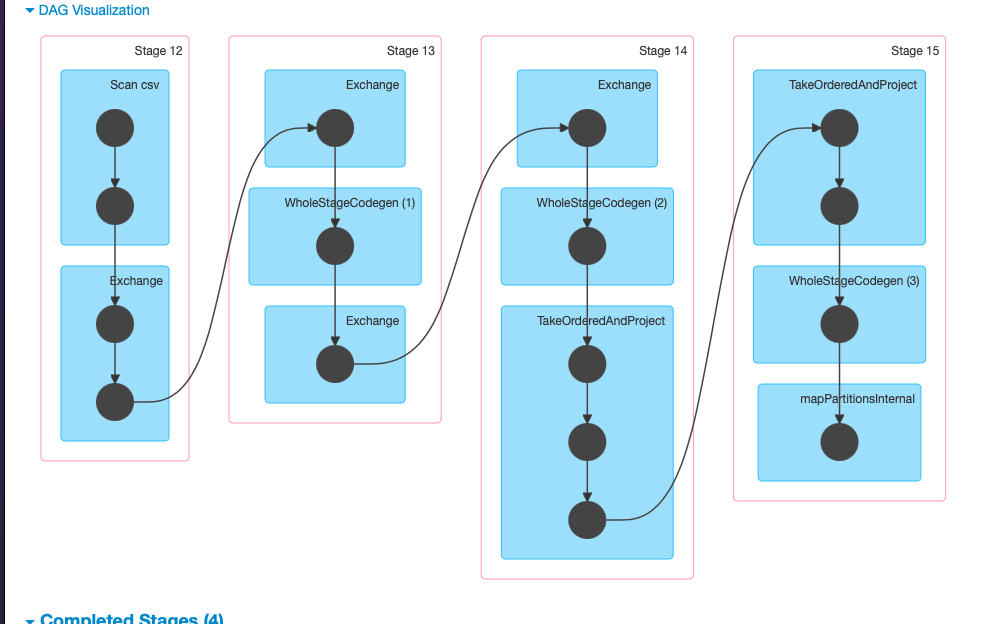

In [ ]:
#df_zones = spark.read \
#    .option("header", "true") \
#    .csv('taxi+_zone_lookup.csv')
#df_zones.write.parquet('zones')

In [78]:
df_zones = spark.read.parquet('zones')
df_zones.registerTempTable('zones')
df_zones.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [81]:
df_join_1 = df.join(df_zones, df.PULocationID == df_zones.LocationID, how='inner')\
    .drop('hvfhs_license_num', 'dispatching_base_num', 'SR_Flag', 'LocationID', 'Borough', 'service_zone')\
    .withColumnRenamed('Zone', 'PUZone')
df_join_1.registerTempTable('join_1')

In [23]:
spark.sql("""
SELECT
    *
FROM
    join_1
LIMIT 10
""").show()

+-------------------+-------------------+------------+------------+--------------------+
|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|              PUZone|
+-------------------+-------------------+------------+------------+--------------------+
|2021-02-06 01:18:35|2021-02-06 01:40:34|         163|         235|       Midtown North|
|2021-02-05 07:13:06|2021-02-05 07:31:56|         225|         181|  Stuyvesant Heights|
|2021-02-04 16:56:52|2021-02-04 17:21:36|         260|          95|            Woodside|
|2021-02-03 18:34:17|2021-02-03 18:57:12|         235|          60|University Height...|
|2021-02-04 07:25:09|2021-02-04 07:30:34|          55|          55|        Coney Island|
|2021-02-04 23:15:27|2021-02-04 23:34:29|          74|          81|   East Harlem North|
|2021-02-05 07:45:49|2021-02-05 08:05:03|         239|         231|Upper West Side S...|
|2021-02-03 17:33:59|2021-02-03 17:47:14|          95|         196|        Forest Hills|
|2021-02-03 09:33:06|

In [82]:
df_join_2 = df_join_1.join(df_zones, df.DOLocationID == df_zones.LocationID, how='inner')\
    .drop('LocationID', 'Borough', 'service_zone')\
    .withColumnRenamed('Zone', 'DOZone')
df_join_2.registerTempTable('join_2')

In [85]:
spark.sql("""
SELECT
    *
FROM
    join_2
LIMIT 10
""").show()

+-------------------+-------------------+------------+------------+--------------------+--------------------+
|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|              PUZone|              DOZone|
+-------------------+-------------------+------------+------------+--------------------+--------------------+
|2021-02-06 01:18:35|2021-02-06 01:40:34|         163|         235|       Midtown North|University Height...|
|2021-02-05 07:13:06|2021-02-05 07:31:56|         225|         181|  Stuyvesant Heights|          Park Slope|
|2021-02-04 16:56:52|2021-02-04 17:21:36|         260|          95|            Woodside|        Forest Hills|
|2021-02-03 18:34:17|2021-02-03 18:57:12|         235|          60|University Height...|   Crotona Park East|
|2021-02-04 07:25:09|2021-02-04 07:30:34|          55|          55|        Coney Island|        Coney Island|
|2021-02-04 23:15:27|2021-02-04 23:34:29|          74|          81|   East Harlem North|         Eastchester|
|2021-02-0

In [87]:
spark.sql("""
SELECT
    PULocationID,
    DOLocationID,
    PUZone,
    DOZone,
    COUNT(*)
FROM
    join_2
GROUP BY 1, 2, 3, 4
ORDER BY 5 DESC
LIMIT 1
""").show()

+------------+------------+-------------+-------------+--------+
|PULocationID|DOLocationID|       PUZone|       DOZone|count(1)|
+------------+------------+-------------+-------------+--------+
|          76|          76|East New York|East New York|   45041|
+------------+------------+-------------+-------------+--------+



Q6) 👆